# **Creating data files for the Hugging Face summary tutorial**

Since the dataset was deleted, due to Amazon licensing reasons and because no matching corpus could be found on Hugging Face, we need to create our own datasets. After searching, I found this corpus: [buruzaemon/amazon_reviews_multi](https://huggingface.co/datasets/buruzaemon/amazon_reviews_multi). We manually downloaded the corpus files and temporarily created a private dataset.

## **Load libraries**



In [1]:
%pip install -qqq polars<1.22,>=1.20
%pip install -qqq -U huggingface_hub
%pip install -qqq -U datasets

/bin/bash: line 1: 1.22,: No such file or directory
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 11.2 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 10.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0

In [2]:
%pip show polars
%pip show huggingface_hub
%pip show datasets

Name: polars
Version: 1.21.0
Summary: Blazingly fast DataFrame library
Home-page: https://www.pola.rs/
Author: 
Author-email: Ritchie Vink <ritchie46@gmail.com>
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: 
Required-by: cudf-polars-cu12
Note: you may need to restart the kernel to use updated packages.
Name: huggingface-hub
Version: 0.34.4
Summary: Client library to download and publish models, datasets and other repos on the huggingface.co hub
Home-page: https://github.com/huggingface/huggingface_hub
Author: Hugging Face, Inc.
Author-email: julien@huggingface.co
License: Apache
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, hf-xet, packaging, pyyaml, requests, tqdm, typing-extensions
Required-by: accelerate, datasets, diffusers, gradio, gradio_client, peft, sentence-transformers, timm, tokenizers, torchtune, transformers
Note: you may need to restart the kernel to use updated packages.
Name: datasets
Version: 4.0.0
Summary: Huggin

In [3]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


## **Imports**

In [4]:
import zipfile
import os, sys
import shutil
import json
import random
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
import pyarrow as pa

import pyarrow.parquet as pq

from kaggle_secrets import UserSecretsClient

from datasets import Dataset, DatasetDict

from huggingface_hub import (
    Repository, 
    get_full_repo_name,
    login,
    upload_folder,
    hf_hub_download,
    HfApi
)

## **Hugging Face Login**

In [5]:
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
user_email = user_secrets.get_secret("user_email")
user_name = user_secrets.get_secret("user_name")

login(token=hf_token)

***You will need to set up git, edit your email and name.***

In [6]:
def set_git_config(email, name):
    try:
        # Setting global user.email
        subprocess.run(["git", "config", "--global", "user.email", email], check=True)
        #print(f"Git user.email set to: {email}")
        
        # Setting the global user.name
        subprocess.run(["git", "config", "--global", "user.name", name], check=True)
        #print(f"Git user.name set to: {name}")
        
        # Check settings (optional)
        email_output = subprocess.run(["git", "config", "--global", "user.email"], capture_output=True, text=True, check=True)
        name_output = subprocess.run(["git", "config", "--global", "user.name"], capture_output=True, text=True, check=True)
        #print(f"Check - Email: {email_output.stdout.strip()}")
        #print(f"Check - Name: {name_output.stdout.strip()}")
        
    except subprocess.CalledProcessError as e:
        print(f"Error while setting up Git configuration: {e}")

In [7]:
set_git_config(user_email, user_name)

## **Load datasets to the polars**

### ***Paths files***

In [8]:
base_path_input = os.path.join('/kaggle', 'input', 'the-multilingual-amazon-reviews-corpus', 'amazon_reviews_multi')

# English language

path_en_test = os.path.join(base_path_input, 'en', 'test.jsonl') # test data
path_en_train = os.path.join(base_path_input, 'en', 'train.jsonl') # train data
path_en_valid = os.path.join(base_path_input, 'en', 'validation.jsonl') # validation data

# German language

path_de_test = os.path.join(base_path_input, 'de', 'test.jsonl') # test data
path_de_train = os.path.join(base_path_input, 'de', 'train.jsonl') # train data
path_de_valid = os.path.join(base_path_input, 'de', 'validation.jsonl') # validation data

# French language

path_fr_test = os.path.join(base_path_input, 'fr', 'test.jsonl') # test data
path_fr_train = os.path.join(base_path_input, 'fr', 'train.jsonl') # train data
path_fr_valid = os.path.join(base_path_input, 'fr', 'validation.jsonl') # validation data

# Spanish language

path_es_test = os.path.join(base_path_input, 'es', 'test.jsonl') # test data
path_es_train = os.path.join(base_path_input, 'es', 'train.jsonl') # train data
path_es_valid = os.path.join(base_path_input, 'es', 'validation.jsonl') # validation data

# Japanese language

path_ja_test = os.path.join(base_path_input, 'ja', 'test.jsonl') # test data
path_ja_train = os.path.join(base_path_input, 'ja', 'train.jsonl') # train data
path_ja_valid = os.path.join(base_path_input, 'ja', 'validation.jsonl') # validation data

# Chinese language

path_zh_test = os.path.join(base_path_input, 'zh', 'test.jsonl') # test data
path_zh_train = os.path.join(base_path_input, 'zh', 'train.jsonl') # train data
path_zh_valid = os.path.join(base_path_input, 'zh', 'validation.jsonl') # validation data

## **Load JSON files** 

In [9]:

def load_json_file_to_polars(path_file):
    json_lines_list = []
    with open(path_file, "r") as f:
        for line in f:
            json_lines_list.append(json.loads(line))
    
    # Create a Polars DataFrame from the list of dictionaries
    df = pl.DataFrame(json_lines_list)
    return df

### ***Polars dataframes***

In [10]:
%%time
# create dataframes

en_pl_dataframe_test = load_json_file_to_polars(path_en_test)
en_pl_dataframe_train = load_json_file_to_polars(path_en_train)
en_pl_dataframe_valid = load_json_file_to_polars(path_en_valid)

de_pl_dataframe_test = load_json_file_to_polars(path_de_test)
de_pl_dataframe_train = load_json_file_to_polars(path_de_train)
de_pl_dataframe_valid = load_json_file_to_polars(path_de_valid)

fr_pl_dataframe_test = load_json_file_to_polars(path_fr_test)
fr_pl_dataframe_train = load_json_file_to_polars(path_fr_train)
fr_pl_dataframe_valid = load_json_file_to_polars(path_fr_valid)

es_pl_dataframe_test = load_json_file_to_polars(path_es_test)
es_pl_dataframe_train = load_json_file_to_polars(path_es_train)
es_pl_dataframe_valid = load_json_file_to_polars(path_es_valid)

ja_pl_dataframe_test = load_json_file_to_polars(path_ja_test)
ja_pl_dataframe_train = load_json_file_to_polars(path_ja_train)
ja_pl_dataframe_valid = load_json_file_to_polars(path_ja_valid)

zh_pl_dataframe_test = load_json_file_to_polars(path_zh_test)
zh_pl_dataframe_train = load_json_file_to_polars(path_zh_train)
zh_pl_dataframe_valid = load_json_file_to_polars(path_zh_valid)

CPU times: user 13.2 s, sys: 2.94 s, total: 16.2 s
Wall time: 19.5 s


## **Show datasets**

### **English**

In [11]:
en_pl_dataframe_test.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""en_0199937""","""product_en_0902516""","""reviewer_en_0097389""",1,"""These are AWFUL. They are see …","""Don’t waste your time!""","""en""","""apparel"""
"""en_0863335""","""product_en_0348072""","""reviewer_en_0601537""",1,"""I bought 4 and NONE of them wo…","""One Star""","""en""","""other"""
"""en_0565010""","""product_en_0356154""","""reviewer_en_0970351""",1,"""On first use it didn't heat up…","""Totally useless""","""en""","""other"""


In [12]:
print('Number of rows:', en_pl_dataframe_test.shape[0])
print('Number of columns:', en_pl_dataframe_test.shape[1])

Number of rows: 5000
Number of columns: 8


In [13]:
en_pl_dataframe_train.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""en_0964290""","""product_en_0740675""","""reviewer_en_0342986""",1,"""Arrived broken. Manufacturer d…","""I'll spend twice the amount of…","""en""","""furniture"""
"""en_0690095""","""product_en_0440378""","""reviewer_en_0133349""",1,"""the cabinet dot were all detac…","""Not use able""","""en""","""home_improvement"""
"""en_0311558""","""product_en_0399702""","""reviewer_en_0152034""",1,"""I received my first order of t…","""The product is junk.""","""en""","""home"""


In [14]:
print('Number of rows:', en_pl_dataframe_train.shape[0])
print('Number of columns:', en_pl_dataframe_train.shape[1])

Number of rows: 200000
Number of columns: 8


In [15]:
en_pl_dataframe_valid.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""en_0968227""","""product_en_0878845""","""reviewer_en_0987470""",1,"""Pathetic design of the caps. V…","""Not worth the price and very b…","""en""","""baby_product"""
"""en_0830781""","""product_en_0004522""","""reviewer_en_0731158""",1,"""Shoes were purchased on March …","""Garbage!""","""en""","""shoes"""
"""en_0277954""","""product_en_0060687""","""reviewer_en_0793876""",1,"""It's taken me 1 whole year to …","""I do not recommend this printe…","""en""","""office_product"""


In [16]:
print('Number of rows:', en_pl_dataframe_valid.shape[0])
print('Number of columns:', en_pl_dataframe_valid.shape[1])

Number of rows: 5000
Number of columns: 8


### **German**

In [17]:
de_pl_dataframe_test.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""de_0784695""","""product_de_0572654""","""reviewer_de_0645436""",1,"""Leider, leider nach einmal was…","""Leider nicht zu empfehlen""","""de""","""home"""
"""de_0759207""","""product_de_0567331""","""reviewer_de_0183703""",1,"""zunächst macht der Anker Halte…","""Gummierung nach 6 Monaten kapu…","""de""","""wireless"""
"""de_0711785""","""product_de_0482105""","""reviewer_de_0182152""",1,"""Siegel sowie Verpackung war be…","""Flohmarkt ware""","""de""","""industrial_supplies"""


In [18]:
print('Number of rows:', de_pl_dataframe_test.shape[0])
print('Number of columns:', de_pl_dataframe_test.shape[1])

Number of rows: 5000
Number of columns: 8


In [19]:
de_pl_dataframe_train.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""de_0203609""","""product_de_0865382""","""reviewer_de_0267719""",1,"""Armband ist leider nach 1 Jahr…","""Leider nach 1 Jahr kaputt""","""de""","""sports"""
"""de_0559494""","""product_de_0678997""","""reviewer_de_0783625""",1,"""In der Lieferung war nur Ein A…","""EINS statt ZWEI Akkus!!!""","""de""","""home_improvement"""
"""de_0238777""","""product_de_0372235""","""reviewer_de_0911426""",1,"""Ein Stern, weil gar keine geht…","""Achtung Abzocke""","""de""","""drugstore"""


In [20]:
print('Number of rows:', de_pl_dataframe_train.shape[0])
print('Number of columns:', de_pl_dataframe_train.shape[1])

Number of rows: 200000
Number of columns: 8


In [21]:
de_pl_dataframe_valid.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""de_0591095""","""product_de_0301773""","""reviewer_de_0787123""",1,"""Das Produkt kam bis heute nich…","""Produkte NICHT geliefert""","""de""","""toy"""
"""de_0987834""","""product_de_0720578""","""reviewer_de_0983846""",1,"""Gebrauchte Spinner, teilzerleg…","""Gebrauchtware, ekelhaft""","""de""","""toy"""
"""de_0978206""","""product_de_0499114""","""reviewer_de_0238704""",1,"""Bei beiden Bestellungen war je…","""Sehr schlechte Qualität""","""de""","""home"""


In [22]:
print('Number of rows:', de_pl_dataframe_valid.shape[0])
print('Number of columns:', de_pl_dataframe_valid.shape[1])

Number of rows: 5000
Number of columns: 8


### ***French***

In [23]:
fr_pl_dataframe_test.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""fr_0797681""","""product_fr_0072745""","""reviewer_fr_0724113""",1,"""Ca c'est du vol... Vous ne rec…","""ARNAQUE""","""fr""","""home_improvement"""
"""fr_0329266""","""product_fr_0182588""","""reviewer_fr_0116929""",1,"""Presque 1 mois après la comman…","""NON REÇU!!!!""","""fr""","""baby_product"""
"""fr_0745602""","""product_fr_0542787""","""reviewer_fr_0704676""",1,"""Amazon n’a pu me livrer ce pro…","""État d’âme""","""fr""","""home_improvement"""


In [24]:
print('Number of rows:', fr_pl_dataframe_test.shape[0])
print('Number of columns:', fr_pl_dataframe_test.shape[1])

Number of rows: 5000
Number of columns: 8


In [25]:
fr_pl_dataframe_train.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""fr_0424335""","""product_fr_0297678""","""reviewer_fr_0961886""",1,"""A déconseiller - Article n'a f…","""Brumisateur à pompe""","""fr""","""beauty"""
"""fr_0452615""","""product_fr_0613288""","""reviewer_fr_0857499""",1,"""Si vous voulez être déçu achet…","""Insatisfaisant""","""fr""","""baby_product"""
"""fr_0407673""","""product_fr_0571250""","""reviewer_fr_0383240""",1,"""Écran de mauvaise qualité, car…","""Ne recommande pas""","""fr""","""pc"""


In [26]:
print('Number of rows:', fr_pl_dataframe_train.shape[0])
print('Number of columns:', fr_pl_dataframe_train.shape[1])

Number of rows: 200000
Number of columns: 8


In [27]:
fr_pl_dataframe_valid.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""fr_0112905""","""product_fr_0620743""","""reviewer_fr_0310864""",1,"""Colis bien reçus avec le boîti…","""Commandé ailleurs si vous voul…","""fr""","""video_games"""
"""fr_0345365""","""product_fr_0942745""","""reviewer_fr_0244013""",1,"""Suite à une vérification, je v…","""COMMANDE NON RECUE""","""fr""","""office_product"""
"""fr_0474170""","""product_fr_0183830""","""reviewer_fr_0816879""",1,"""C'est un produit de piètre qua…","""Plastique sans aucune résistan…","""fr""","""automotive"""


In [28]:
print('Number of rows:', fr_pl_dataframe_valid.shape[0])
print('Number of columns:', fr_pl_dataframe_valid.shape[1])

Number of rows: 5000
Number of columns: 8


### ***Spanish***

In [29]:
es_pl_dataframe_test.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""es_0038754""","""product_es_0113523""","""reviewer_es_0580071""",1,"""no me llego el articulo me lo …","""no me llego""","""es""","""wireless"""
"""es_0748979""","""product_es_0017036""","""reviewer_es_0819733""",1,"""la mensajería horrible, no com…","""amazon sigue sin cumplir en la…","""es""","""home"""
"""es_0411746""","""product_es_0138642""","""reviewer_es_0508607""",1,"""Estoy muy decepcionado con el …","""ESTAFA EN EL ENVÍO""","""es""","""toy"""


In [30]:
print('Number of rows:', es_pl_dataframe_test.shape[0])
print('Number of columns:', es_pl_dataframe_test.shape[1])

Number of rows: 5000
Number of columns: 8


In [31]:
es_pl_dataframe_train.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""es_0491108""","""product_es_0296024""","""reviewer_es_0999081""",1,"""Nada bueno se me fue ka pantal…","""television Nevir""","""es""","""electronics"""
"""es_0869872""","""product_es_0922286""","""reviewer_es_0216771""",1,"""Horrible, nos tuvimos que comp…","""Dinero tirado a la basura con …","""es""","""electronics"""
"""es_0811721""","""product_es_0474543""","""reviewer_es_0929213""",1,"""Te obligan a comprar dos unida…","""solo llega una unidad cuando t…","""es""","""drugstore"""


In [32]:
print('Number of rows:', es_pl_dataframe_train.shape[0])
print('Number of columns:', es_pl_dataframe_train.shape[1])

Number of rows: 200000
Number of columns: 8


In [33]:
es_pl_dataframe_valid.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""es_0417480""","""product_es_0873923""","""reviewer_es_0672978""",1,"""Malisimo, muy grande demasiado…","""Mala compra""","""es""","""wireless"""
"""es_0180432""","""product_es_0713146""","""reviewer_es_0100858""",1,"""No he recibido el pedido no la…","""No lo he recibido""","""es""","""apparel"""
"""es_0144850""","""product_es_0356874""","""reviewer_es_0486447""",1,"""Tengo que buscar otro sistema,…","""Que no aprieta bien en el mani…","""es""","""sports"""


In [34]:
print('Number of rows:', es_pl_dataframe_valid.shape[0])
print('Number of columns:', es_pl_dataframe_valid.shape[1])

Number of rows: 5000
Number of columns: 8


### ***Japanese***

In [35]:
ja_pl_dataframe_test.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""ja_0233954""","""product_ja_0660151""","""reviewer_ja_0015514""",1,"""購入、貼付け後2週間もたたないうちに、上側から剥がれてきて画…","""剥がれて浮いてきた""","""ja""","""wireless"""
"""ja_0795959""","""product_ja_0898248""","""reviewer_ja_0391362""",1,"""以下の3点の理由により、期待はずれの粗悪品。 ①他の方のレビ…","""所詮は中国製クオリティー・・・""","""ja""","""home"""
"""ja_0162615""","""product_ja_0617857""","""reviewer_ja_0746160""",1,"""この商品の内容等確認した購入したのですが、そのとおりなかなか…","""デジタルフォトステージが思うようにいかない""","""ja""","""camera"""


In [36]:
print('Number of rows:', ja_pl_dataframe_test.shape[0])
print('Number of columns:', ja_pl_dataframe_test.shape[1])

Number of rows: 5000
Number of columns: 8


In [37]:
ja_pl_dataframe_train.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""ja_0388536""","""product_ja_0270003""","""reviewer_ja_0454098""",1,"""普段使いとバイクに乗るときのブーツ兼用として購入しました。見…","""本革でも防水でもない""","""ja""","""shoes"""
"""ja_0701307""","""product_ja_0540923""","""reviewer_ja_0635293""",1,"""十分な在庫を用意できない販売元も悪いですが、Amazonやら…","""Amazonが転売を認めてるから…""","""ja""","""video_games"""
"""ja_0724445""","""product_ja_0113803""","""reviewer_ja_0598011""",1,"""見た目はかなりおしゃれで気に入りました。2、3回持ち歩いた後…","""時計として使えません。""","""ja""","""watch"""


In [38]:
print('Number of rows:', ja_pl_dataframe_train.shape[0])
print('Number of columns:', ja_pl_dataframe_train.shape[1])

Number of rows: 200000
Number of columns: 8


In [39]:
ja_pl_dataframe_valid.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""ja_0442576""","""product_ja_0142340""","""reviewer_ja_0067777""",1,"""味自体及び吸い心地は良いのだが、不良品が多過ぎる。私の場合５…","""不良品""","""ja""","""drugstore"""
"""ja_0944897""","""product_ja_0821731""","""reviewer_ja_0192786""",1,"""ホームボタン周りの気泡が全く抜けません。 返金をお願いしまし…","""欠陥品""","""ja""","""wireless"""
"""ja_0564525""","""product_ja_0164374""","""reviewer_ja_0468875""",1,"""新旧含めて4つのカーテンレールがあるのですが、使用出来るカー…","""我が家のカーテンレールでは全て使用出来ませんでした""","""ja""","""home"""


In [40]:
print('Number of rows:', ja_pl_dataframe_valid.shape[0])
print('Number of columns:', ja_pl_dataframe_valid.shape[1])

Number of rows: 5000
Number of columns: 8


### ***Chinese***

In [41]:
zh_pl_dataframe_test.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""zh_0932578""","""product_zh_0277983""","""reviewer_zh_0157493""",1,"""买的两百多的，不是真货，和真的对比了小一圈！特别不好跟30多…","""假货""","""zh""","""baby_product"""
"""zh_0119456""","""product_zh_0066702""","""reviewer_zh_0810542""",1,"""怎么包装盒都没有，就一个塑料袋装了几张面膜，一看就掉了好几个…","""打开吓一跳！""","""zh""","""beauty"""
"""zh_0070808""","""product_zh_0324298""","""reviewer_zh_0925149""",1,"""差到几点的电池！充电一天！用不到一个小时就没电！怎么给小孩带…","""垃圾车""","""zh""","""toy"""


In [42]:
print('Number of rows:', zh_pl_dataframe_test.shape[0])
print('Number of columns:', zh_pl_dataframe_test.shape[1])

Number of rows: 5000
Number of columns: 8


In [43]:
zh_pl_dataframe_train.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""zh_0626061""","""product_zh_0691762""","""reviewer_zh_0824776""",1,"""本人账号被盗，资金被江西（杨建）挪用，请亚马逊尽快查实，将本…","""此书不是本人购买""","""zh""","""book"""
"""zh_0713738""","""product_zh_0123483""","""reviewer_zh_0518940""",1,"""这简直就是太差了！出版社怎么就能出版吗？我以为是百度摘录呢！…","""简直是废话！""","""zh""","""book"""
"""zh_0621612""","""product_zh_0670618""","""reviewer_zh_0040023""",1,"""购买页面显示1～2日发货，付款之后显示半个月后送达，实际收到…","""最牛逼的预售""","""zh""","""home_improvement"""


In [44]:
print('Number of rows:', zh_pl_dataframe_train.shape[0])
print('Number of columns:', zh_pl_dataframe_train.shape[1])

Number of rows: 200000
Number of columns: 8


In [45]:
zh_pl_dataframe_valid.head(3)

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i64,str,str,str,str
"""zh_0048844""","""product_zh_0873012""","""reviewer_zh_0442758""",1,"""配送了很长时间，最后通知我被退货了，无奈选择其他。 sorr…","""不喜欢""","""zh""","""personal_care_appliances"""
"""zh_0898277""","""product_zh_0683850""","""reviewer_zh_0382495""",1,"""非常挤脚，所以货拿到试了一下，压得脚背痛，就申请了退货。可是…","""为什么欺骗消费者！""","""zh""","""shoes"""
"""zh_0860983""","""product_zh_0152526""","""reviewer_zh_0759462""",1,"""挤都挤不出来，劣质，已经扔了。好不容易弄出一点，擦在皮肤上，…","""很劣质，挤都挤不出来。""","""zh""","""beauty"""


In [46]:
print('Number of rows:', zh_pl_dataframe_valid.shape[0])
print('Number of columns:', zh_pl_dataframe_valid.shape[1])

Number of rows: 5000
Number of columns: 8


## **Merging into a single language dataset**

In [47]:
list_en_data = [en_pl_dataframe_test, en_pl_dataframe_train, en_pl_dataframe_valid]
list_de_data = [de_pl_dataframe_test, de_pl_dataframe_train, de_pl_dataframe_valid]
list_fr_data = [fr_pl_dataframe_test, fr_pl_dataframe_train, fr_pl_dataframe_valid]
list_es_data = [es_pl_dataframe_test, es_pl_dataframe_train, es_pl_dataframe_valid]
list_jp_data = [ja_pl_dataframe_test, ja_pl_dataframe_train, ja_pl_dataframe_valid]
list_zh_data = [zh_pl_dataframe_test, zh_pl_dataframe_train, zh_pl_dataframe_valid]

### ***English***

In [48]:
%%time
en_pl_dataframe = pl.concat(list_en_data)
print(en_pl_dataframe.head(3))
print(en_pl_dataframe.shape)

shape: (3, 8)
┌────────────┬─────────────┬─────────────┬───────┬────────────┬────────────┬──────────┬────────────┐
│ review_id  ┆ product_id  ┆ reviewer_id ┆ stars ┆ review_bod ┆ review_tit ┆ language ┆ product_ca │
│ ---        ┆ ---         ┆ ---         ┆ ---   ┆ y          ┆ le         ┆ ---      ┆ tegory     │
│ str        ┆ str         ┆ str         ┆ i64   ┆ ---        ┆ ---        ┆ str      ┆ ---        │
│            ┆             ┆             ┆       ┆ str        ┆ str        ┆          ┆ str        │
╞════════════╪═════════════╪═════════════╪═══════╪════════════╪════════════╪══════════╪════════════╡
│ en_0199937 ┆ product_en_ ┆ reviewer_en ┆ 1     ┆ These are  ┆ Don’t      ┆ en       ┆ apparel    │
│            ┆ 0902516     ┆ _0097389    ┆       ┆ AWFUL.     ┆ waste your ┆          ┆            │
│            ┆             ┆             ┆       ┆ They are   ┆ time!      ┆          ┆            │
│            ┆             ┆             ┆       ┆ see …      ┆            ┆ 

### ***German***

In [49]:
%%time
de_pl_dataframe = pl.concat(list_de_data)
print(de_pl_dataframe.head(3))
print(de_pl_dataframe.shape)

shape: (3, 8)
┌────────────┬─────────────┬─────────────┬───────┬────────────┬────────────┬──────────┬────────────┐
│ review_id  ┆ product_id  ┆ reviewer_id ┆ stars ┆ review_bod ┆ review_tit ┆ language ┆ product_ca │
│ ---        ┆ ---         ┆ ---         ┆ ---   ┆ y          ┆ le         ┆ ---      ┆ tegory     │
│ str        ┆ str         ┆ str         ┆ i64   ┆ ---        ┆ ---        ┆ str      ┆ ---        │
│            ┆             ┆             ┆       ┆ str        ┆ str        ┆          ┆ str        │
╞════════════╪═════════════╪═════════════╪═══════╪════════════╪════════════╪══════════╪════════════╡
│ de_0784695 ┆ product_de_ ┆ reviewer_de ┆ 1     ┆ Leider,    ┆ Leider     ┆ de       ┆ home       │
│            ┆ 0572654     ┆ _0645436    ┆       ┆ leider     ┆ nicht zu   ┆          ┆            │
│            ┆             ┆             ┆       ┆ nach       ┆ empfehlen  ┆          ┆            │
│            ┆             ┆             ┆       ┆ einmal     ┆            ┆ 

### ***French***

In [50]:
%%time
fr_pl_dataframe = pl.concat(list_fr_data)
print(fr_pl_dataframe.head(3))
print(fr_pl_dataframe.shape)

shape: (3, 8)
┌────────────┬─────────────┬─────────────┬───────┬────────────┬────────────┬──────────┬────────────┐
│ review_id  ┆ product_id  ┆ reviewer_id ┆ stars ┆ review_bod ┆ review_tit ┆ language ┆ product_ca │
│ ---        ┆ ---         ┆ ---         ┆ ---   ┆ y          ┆ le         ┆ ---      ┆ tegory     │
│ str        ┆ str         ┆ str         ┆ i64   ┆ ---        ┆ ---        ┆ str      ┆ ---        │
│            ┆             ┆             ┆       ┆ str        ┆ str        ┆          ┆ str        │
╞════════════╪═════════════╪═════════════╪═══════╪════════════╪════════════╪══════════╪════════════╡
│ fr_0797681 ┆ product_fr_ ┆ reviewer_fr ┆ 1     ┆ Ca c'est   ┆ ARNAQUE    ┆ fr       ┆ home_impro │
│            ┆ 0072745     ┆ _0724113    ┆       ┆ du vol...  ┆            ┆          ┆ vement     │
│            ┆             ┆             ┆       ┆ Vous ne    ┆            ┆          ┆            │
│            ┆             ┆             ┆       ┆ rec…       ┆            ┆ 

### ***Spanish***

In [51]:
%%time
es_pl_dataframe = pl.concat(list_es_data)
print(es_pl_dataframe.head(3))
print(es_pl_dataframe.shape)

shape: (3, 8)
┌────────────┬─────────────┬─────────────┬───────┬────────────┬────────────┬──────────┬────────────┐
│ review_id  ┆ product_id  ┆ reviewer_id ┆ stars ┆ review_bod ┆ review_tit ┆ language ┆ product_ca │
│ ---        ┆ ---         ┆ ---         ┆ ---   ┆ y          ┆ le         ┆ ---      ┆ tegory     │
│ str        ┆ str         ┆ str         ┆ i64   ┆ ---        ┆ ---        ┆ str      ┆ ---        │
│            ┆             ┆             ┆       ┆ str        ┆ str        ┆          ┆ str        │
╞════════════╪═════════════╪═════════════╪═══════╪════════════╪════════════╪══════════╪════════════╡
│ es_0038754 ┆ product_es_ ┆ reviewer_es ┆ 1     ┆ no me      ┆ no me      ┆ es       ┆ wireless   │
│            ┆ 0113523     ┆ _0580071    ┆       ┆ llego el   ┆ llego      ┆          ┆            │
│            ┆             ┆             ┆       ┆ articulo   ┆            ┆          ┆            │
│            ┆             ┆             ┆       ┆ me lo …    ┆            ┆ 

### ***Japanese***

In [52]:
%%time
ja_pl_dataframe = pl.concat(list_jp_data)
print(ja_pl_dataframe.head(3))
print(ja_pl_dataframe.shape)

shape: (3, 8)
┌────────────┬─────────────┬─────────────┬───────┬────────────┬────────────┬──────────┬────────────┐
│ review_id  ┆ product_id  ┆ reviewer_id ┆ stars ┆ review_bod ┆ review_tit ┆ language ┆ product_ca │
│ ---        ┆ ---         ┆ ---         ┆ ---   ┆ y          ┆ le         ┆ ---      ┆ tegory     │
│ str        ┆ str         ┆ str         ┆ i64   ┆ ---        ┆ ---        ┆ str      ┆ ---        │
│            ┆             ┆             ┆       ┆ str        ┆ str        ┆          ┆ str        │
╞════════════╪═════════════╪═════════════╪═══════╪════════════╪════════════╪══════════╪════════════╡
│ ja_0233954 ┆ product_ja_ ┆ reviewer_ja ┆ 1     ┆ 購入、貼付 ┆ 剥がれて浮 ┆ ja       ┆ wireless   │
│            ┆ 0660151     ┆ _0015514    ┆       ┆ け後2週間  ┆ いてきた   ┆          ┆            │
│            ┆             ┆             ┆       ┆ もたたない ┆            ┆          ┆            │
│            ┆             ┆             ┆       ┆ うちに、上 ┆            ┆          ┆            │
│   

### ***Chinese***

In [53]:
%%time
zh_pl_dataframe = pl.concat(list_zh_data)
print(zh_pl_dataframe.head(3))
print(zh_pl_dataframe.shape)

shape: (3, 8)
┌────────────┬─────────────┬─────────────┬───────┬────────────┬────────────┬──────────┬────────────┐
│ review_id  ┆ product_id  ┆ reviewer_id ┆ stars ┆ review_bod ┆ review_tit ┆ language ┆ product_ca │
│ ---        ┆ ---         ┆ ---         ┆ ---   ┆ y          ┆ le         ┆ ---      ┆ tegory     │
│ str        ┆ str         ┆ str         ┆ i64   ┆ ---        ┆ ---        ┆ str      ┆ ---        │
│            ┆             ┆             ┆       ┆ str        ┆ str        ┆          ┆ str        │
╞════════════╪═════════════╪═════════════╪═══════╪════════════╪════════════╪══════════╪════════════╡
│ zh_0932578 ┆ product_zh_ ┆ reviewer_zh ┆ 1     ┆ 买的两百多 ┆ 假货       ┆ zh       ┆ baby_produ │
│            ┆ 0277983     ┆ _0157493    ┆       ┆ 的，不是真 ┆            ┆          ┆ ct         │
│            ┆             ┆             ┆       ┆ 货，和真的 ┆            ┆          ┆            │
│            ┆             ┆             ┆       ┆ 对比了小一 ┆            ┆          ┆            

## **Detecting and removing duplicates**

### ***English***

In [54]:
%%time
en_pl_dataframe_duplicates = en_pl_dataframe.group_by(["review_id","product_id","reviewer_id"]).agg(count=pl.col("review_id").count()).filter(pl.col("count") > 1)
print("Duplicets values:\n", en_pl_dataframe_duplicates)

Duplicets values:
 shape: (0, 4)
┌───────────┬────────────┬─────────────┬───────┐
│ review_id ┆ product_id ┆ reviewer_id ┆ count │
│ ---       ┆ ---        ┆ ---         ┆ ---   │
│ str       ┆ str        ┆ str         ┆ u32   │
╞═══════════╪════════════╪═════════════╪═══════╡
└───────────┴────────────┴─────────────┴───────┘
CPU times: user 146 ms, sys: 138 ms, total: 283 ms
Wall time: 200 ms


In [55]:
%%time
en_pl_dataframe_clean = en_pl_dataframe.unique(subset=["review_id","product_id","reviewer_id"], keep="first")
print(en_pl_dataframe_clean.shape)

(210000, 8)
CPU times: user 129 ms, sys: 48.7 ms, total: 178 ms
Wall time: 77.8 ms


### ***German***

In [56]:
%%time
de_pl_dataframe_duplicates = de_pl_dataframe.group_by(["review_id","product_id","reviewer_id"]).agg(count=pl.col("review_id").count()).filter(pl.col("count") > 1)
print("Duplicets values:\n", de_pl_dataframe_duplicates)

Duplicets values:
 shape: (0, 4)
┌───────────┬────────────┬─────────────┬───────┐
│ review_id ┆ product_id ┆ reviewer_id ┆ count │
│ ---       ┆ ---        ┆ ---         ┆ ---   │
│ str       ┆ str        ┆ str         ┆ u32   │
╞═══════════╪════════════╪═════════════╪═══════╡
└───────────┴────────────┴─────────────┴───────┘
CPU times: user 115 ms, sys: 73.1 ms, total: 188 ms
Wall time: 82.4 ms


In [57]:
%%time
de_pl_dataframe_clean = de_pl_dataframe.unique(subset=["review_id","product_id","reviewer_id"], keep="first")
print(de_pl_dataframe_clean.shape)

(210000, 8)
CPU times: user 127 ms, sys: 34.5 ms, total: 161 ms
Wall time: 70.5 ms


### ***French***

In [58]:
%%time
fr_pl_dataframe_duplicates = fr_pl_dataframe.group_by(["review_id","product_id","reviewer_id"]).agg(count=pl.col("review_id").count()).filter(pl.col("count") > 1)
print("Duplicets values:\n", fr_pl_dataframe_duplicates)

Duplicets values:
 shape: (0, 4)
┌───────────┬────────────┬─────────────┬───────┐
│ review_id ┆ product_id ┆ reviewer_id ┆ count │
│ ---       ┆ ---        ┆ ---         ┆ ---   │
│ str       ┆ str        ┆ str         ┆ u32   │
╞═══════════╪════════════╪═════════════╪═══════╡
└───────────┴────────────┴─────────────┴───────┘
CPU times: user 120 ms, sys: 77.1 ms, total: 197 ms
Wall time: 81.4 ms


In [59]:
%%time
fr_pl_dataframe_clean = fr_pl_dataframe.unique(subset=["review_id","product_id","reviewer_id"], keep="first")
print(fr_pl_dataframe_clean.shape)

(210000, 8)
CPU times: user 121 ms, sys: 35.6 ms, total: 156 ms
Wall time: 61.8 ms


### ***Spanish***

In [60]:
%%time
es_pl_dataframe_duplicates = es_pl_dataframe.group_by(["review_id","product_id","reviewer_id"]).agg(count=pl.col("review_id").count()).filter(pl.col("count") > 1)
print("Duplicets values:\n", es_pl_dataframe_duplicates)

Duplicets values:
 shape: (0, 4)
┌───────────┬────────────┬─────────────┬───────┐
│ review_id ┆ product_id ┆ reviewer_id ┆ count │
│ ---       ┆ ---        ┆ ---         ┆ ---   │
│ str       ┆ str        ┆ str         ┆ u32   │
╞═══════════╪════════════╪═════════════╪═══════╡
└───────────┴────────────┴─────────────┴───────┘
CPU times: user 121 ms, sys: 64.4 ms, total: 186 ms
Wall time: 77.4 ms


In [61]:
%%time
es_pl_dataframe_clean = es_pl_dataframe.unique(subset=["review_id","product_id","reviewer_id"], keep="first")
print(es_pl_dataframe_clean.shape)

(210000, 8)
CPU times: user 126 ms, sys: 23.3 ms, total: 150 ms
Wall time: 55.9 ms


### ***Japanese***

In [62]:
%%time
ja_pl_dataframe_duplicates = ja_pl_dataframe.group_by(["review_id","product_id","reviewer_id"]).agg(count=pl.col("review_id").count()).filter(pl.col("count") > 1)
print("Duplicets values:\n", ja_pl_dataframe_duplicates)

Duplicets values:
 shape: (0, 4)
┌───────────┬────────────┬─────────────┬───────┐
│ review_id ┆ product_id ┆ reviewer_id ┆ count │
│ ---       ┆ ---        ┆ ---         ┆ ---   │
│ str       ┆ str        ┆ str         ┆ u32   │
╞═══════════╪════════════╪═════════════╪═══════╡
└───────────┴────────────┴─────────────┴───────┘
CPU times: user 133 ms, sys: 108 ms, total: 241 ms
Wall time: 118 ms


In [63]:
%%time
ja_pl_dataframe_clean = ja_pl_dataframe.unique(subset=["review_id","product_id","reviewer_id"], keep="first")
print(ja_pl_dataframe_clean.shape)

(210000, 8)
CPU times: user 133 ms, sys: 45 ms, total: 178 ms
Wall time: 85.7 ms


### ***Chinese***

In [64]:
%%time
zh_pl_dataframe_duplicates = zh_pl_dataframe.group_by(["review_id","product_id","reviewer_id"]).agg(count=pl.col("review_id").count()).filter(pl.col("count") > 1)
print("Duplicets values:\n", zh_pl_dataframe_duplicates)

Duplicets values:
 shape: (0, 4)
┌───────────┬────────────┬─────────────┬───────┐
│ review_id ┆ product_id ┆ reviewer_id ┆ count │
│ ---       ┆ ---        ┆ ---         ┆ ---   │
│ str       ┆ str        ┆ str         ┆ u32   │
╞═══════════╪════════════╪═════════════╪═══════╡
└───────────┴────────────┴─────────────┴───────┘
CPU times: user 120 ms, sys: 75.1 ms, total: 195 ms
Wall time: 77.9 ms


In [65]:
%%time
zh_pl_dataframe_clean = zh_pl_dataframe.unique(subset=["review_id","product_id","reviewer_id"], keep="first")
print(zh_pl_dataframe_clean.shape)

(210000, 8)
CPU times: user 130 ms, sys: 27.6 ms, total: 157 ms
Wall time: 60.5 ms


## **Editing datasets**

For the purposes of NLP work, we are only interested in text data.

### ***Adding text length columns and deleting unnecessary columns***

#### ***English***

In [66]:
en_pl_dataframe_01 = en_pl_dataframe_clean.with_columns(
    lenght_review_body=pl.col("review_body").str.len_chars()
)
en_pl_dataframe_02 = en_pl_dataframe_01.with_columns(
    lenght_review_title=pl.col("review_title").str.len_chars()
)
en_pl_dataframe_add_col = en_pl_dataframe_02.with_columns(
    lenght_product_category=pl.col("product_category").str.len_chars()
)
print(en_pl_dataframe_add_col.head(3))

shape: (3, 11)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ review_id  ┆ product_id ┆ reviewer_i ┆ stars ┆ … ┆ product_c ┆ lenght_re ┆ lenght_re ┆ lenght_pr │
│ ---        ┆ ---        ┆ d          ┆ ---   ┆   ┆ ategory   ┆ view_body ┆ view_titl ┆ oduct_cat │
│ str        ┆ str        ┆ ---        ┆ i64   ┆   ┆ ---       ┆ ---       ┆ e         ┆ egory     │
│            ┆            ┆ str        ┆       ┆   ┆ str       ┆ u32       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆       ┆   ┆           ┆           ┆ u32       ┆ u32       │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ en_0177622 ┆ product_en ┆ reviewer_e ┆ 1     ┆ … ┆ wireless  ┆ 69        ┆ 11        ┆ 8         │
│            ┆ _0357842   ┆ n_0377161  ┆       ┆   ┆           ┆           ┆           ┆           │
│ en_0347871 ┆ product_en ┆ reviewer_e ┆ 1     ┆ … ┆ lawn_and_ ┆ 203       ┆

In [67]:
en_pl_dataframe_finish = en_pl_dataframe_add_col.drop(["review_id","product_id","reviewer_id"]).with_row_index(name="id")
en_pl_dataframe_finish.head(3)

id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
0,1,"""Product was terrible and when …","""Bad product""","""en""","""wireless""",69,11,8
1,1,"""This product is worthless in t…","""Does not work in the garden""","""en""","""lawn_and_garden""",203,27,15
2,3,"""bought for grand daughter she …","""Three Stars""","""en""","""sports""",38,11,6


#### ***German***

In [68]:
de_pl_dataframe_01 = de_pl_dataframe_clean.with_columns(
    lenght_review_body=pl.col("review_body").str.len_chars()
)
de_pl_dataframe_02 = de_pl_dataframe_01.with_columns(
    lenght_review_title=pl.col("review_title").str.len_chars()
)
de_pl_dataframe_add_col = de_pl_dataframe_02.with_columns(
    lenght_product_category=pl.col("product_category").str.len_chars()
)
print(de_pl_dataframe_add_col.head(3))

shape: (3, 11)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ review_id  ┆ product_id ┆ reviewer_i ┆ stars ┆ … ┆ product_c ┆ lenght_re ┆ lenght_re ┆ lenght_pr │
│ ---        ┆ ---        ┆ d          ┆ ---   ┆   ┆ ategory   ┆ view_body ┆ view_titl ┆ oduct_cat │
│ str        ┆ str        ┆ ---        ┆ i64   ┆   ┆ ---       ┆ ---       ┆ e         ┆ egory     │
│            ┆            ┆ str        ┆       ┆   ┆ str       ┆ u32       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆       ┆   ┆           ┆           ┆ u32       ┆ u32       │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ de_0729732 ┆ product_de ┆ reviewer_d ┆ 5     ┆ … ┆ furniture ┆ 127       ┆ 16        ┆ 9         │
│            ┆ _0472442   ┆ e_0452398  ┆       ┆   ┆           ┆           ┆           ┆           │
│ de_0603162 ┆ product_de ┆ reviewer_d ┆ 2     ┆ … ┆ luggage   ┆ 182       ┆

In [69]:
de_pl_dataframe_finish = de_pl_dataframe_add_col.drop(["review_id","product_id","reviewer_id"]).with_row_index(name="id")
de_pl_dataframe_finish.head(3)

id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
0,5,"""Sehr schön als Duschvorleger k…","""Wie auf dem Bild""","""de""","""furniture""",127,16,9
1,2,"""Funktioniert leider nicht , do…","""Zum Spaß für den Preis ganz co…","""de""","""luggage""",182,70,7
2,2,"""Sehr schöne Optik, aber nach 3…","""Schneller Verschleiß""","""de""","""wireless""",72,20,8


#### ***French***

In [70]:
fr_pl_dataframe_01 = fr_pl_dataframe_clean.with_columns(
    lenght_review_body=pl.col("review_body").str.len_chars()
)
fr_pl_dataframe_02 = fr_pl_dataframe_01.with_columns(
    lenght_review_title=pl.col("review_title").str.len_chars()
)
fr_pl_dataframe_add_col = fr_pl_dataframe_02.with_columns(
    lenght_product_category=pl.col("product_category").str.len_chars()
)
print(fr_pl_dataframe_add_col.head(3))

shape: (3, 11)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ review_id  ┆ product_id ┆ reviewer_i ┆ stars ┆ … ┆ product_c ┆ lenght_re ┆ lenght_re ┆ lenght_pr │
│ ---        ┆ ---        ┆ d          ┆ ---   ┆   ┆ ategory   ┆ view_body ┆ view_titl ┆ oduct_cat │
│ str        ┆ str        ┆ ---        ┆ i64   ┆   ┆ ---       ┆ ---       ┆ e         ┆ egory     │
│            ┆            ┆ str        ┆       ┆   ┆ str       ┆ u32       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆       ┆   ┆           ┆           ┆ u32       ┆ u32       │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ fr_0647320 ┆ product_fr ┆ reviewer_f ┆ 1     ┆ … ┆ sports    ┆ 110       ┆ 21        ┆ 6         │
│            ┆ _0035619   ┆ r_0286840  ┆       ┆   ┆           ┆           ┆           ┆           │
│ fr_0265914 ┆ product_fr ┆ reviewer_f ┆ 2     ┆ … ┆ wireless  ┆ 84        ┆

In [71]:
fr_pl_dataframe_finish = fr_pl_dataframe_add_col.drop(["review_id","product_id","reviewer_id"]).with_row_index(name="id")
fr_pl_dataframe_finish.head(3)

id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
0,1,"""le bas qui retient le bidon a …","""porte bidon plastique""","""fr""","""sports""",110,21,6
1,2,"""Protection correcte mais, La f…","""Qualité médiocre""","""fr""","""wireless""",84,16,8
2,2,"""Article livré dans un autre po…","""Livraison""","""fr""","""book""",142,9,4


#### ***Spanish***

In [72]:
es_pl_dataframe_01 = es_pl_dataframe_clean.with_columns(
    lenght_review_body=pl.col("review_body").str.len_chars()
)
es_pl_dataframe_02 = es_pl_dataframe_01.with_columns(
    lenght_review_title=pl.col("review_title").str.len_chars()
)
es_pl_dataframe_add_col = es_pl_dataframe_02.with_columns(
    lenght_product_category=pl.col("product_category").str.len_chars()
)
print(es_pl_dataframe_add_col.head(3))

shape: (3, 11)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ review_id  ┆ product_id ┆ reviewer_i ┆ stars ┆ … ┆ product_c ┆ lenght_re ┆ lenght_re ┆ lenght_pr │
│ ---        ┆ ---        ┆ d          ┆ ---   ┆   ┆ ategory   ┆ view_body ┆ view_titl ┆ oduct_cat │
│ str        ┆ str        ┆ ---        ┆ i64   ┆   ┆ ---       ┆ ---       ┆ e         ┆ egory     │
│            ┆            ┆ str        ┆       ┆   ┆ str       ┆ u32       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆       ┆   ┆           ┆           ┆ u32       ┆ u32       │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ es_0516301 ┆ product_es ┆ reviewer_e ┆ 3     ┆ … ┆ furniture ┆ 144       ┆ 11        ┆ 9         │
│            ┆ _0829586   ┆ s_0864037  ┆       ┆   ┆           ┆           ┆           ┆           │
│ es_0894717 ┆ product_es ┆ reviewer_e ┆ 3     ┆ … ┆ beauty    ┆ 174       ┆

In [73]:
es_pl_dataframe_finish = es_pl_dataframe_add_col.drop(["review_id","product_id","reviewer_id"]).with_row_index(name="id")
es_pl_dataframe_finish.head(3)

id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
0,3,"""sí es totalmente impermeable, …","""Impermeable""","""es""","""furniture""",144,11,9
1,3,"""el precio esta bien del produc…","""el precio bien. pero el embala…","""es""","""beauty""",174,45,6
2,5,"""De momento va muy bien y tiene…","""Lavado rápido y eficiente""","""es""","""other""",54,25,5


### **Japanese**

In [74]:
ja_pl_dataframe_01 = ja_pl_dataframe_clean.with_columns(
    lenght_review_body=pl.col("review_body").str.len_chars()
)
ja_pl_dataframe_02 = ja_pl_dataframe_01.with_columns(
    lenght_review_title=pl.col("review_title").str.len_chars()
)
ja_pl_dataframe_add_col = ja_pl_dataframe_02.with_columns(
    lenght_product_category=pl.col("product_category").str.len_chars()
)
print(ja_pl_dataframe_add_col.head(3))

shape: (3, 11)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ review_id  ┆ product_id ┆ reviewer_i ┆ stars ┆ … ┆ product_c ┆ lenght_re ┆ lenght_re ┆ lenght_pr │
│ ---        ┆ ---        ┆ d          ┆ ---   ┆   ┆ ategory   ┆ view_body ┆ view_titl ┆ oduct_cat │
│ str        ┆ str        ┆ ---        ┆ i64   ┆   ┆ ---       ┆ ---       ┆ e         ┆ egory     │
│            ┆            ┆ str        ┆       ┆   ┆ str       ┆ u32       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆       ┆   ┆           ┆           ┆ u32       ┆ u32       │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ ja_0172244 ┆ product_ja ┆ reviewer_j ┆ 5     ┆ … ┆ beauty    ┆ 75        ┆ 6         ┆ 6         │
│            ┆ _0219865   ┆ a_0657043  ┆       ┆   ┆           ┆           ┆           ┆           │
│ ja_0009433 ┆ product_ja ┆ reviewer_j ┆ 4     ┆ … ┆ pc        ┆ 108       ┆

In [75]:
ja_pl_dataframe_finish = ja_pl_dataframe_add_col.drop(["review_id","product_id","reviewer_id"]).with_row_index(name="id")
ja_pl_dataframe_finish.head(3)

id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
0,5,"""手で洗うより、ふんわりなのに毛穴の奥まで洗えます。ふわふわ泡…","""ボディブラシ""","""ja""","""beauty""",75,6,6
1,4,"""前に使っていたサンワダイレクトのモデルよりおしゃれで気に入っ…","""少しおしゃれな感じで気に入りました。""","""ja""","""pc""",108,18,2
2,5,"""スマホを遊んでいる時、いつもこの枕を使うととても気持ちいいで…","""安心""","""ja""","""kitchen""",32,2,7


### ***Chinese***

In [76]:
zh_pl_dataframe_01 = zh_pl_dataframe_clean.with_columns(
    lenght_review_body=pl.col("review_body").str.len_chars()
)
zh_pl_dataframe_02 = zh_pl_dataframe_01.with_columns(
    lenght_review_title=pl.col("review_title").str.len_chars()
)
zh_pl_dataframe_add_col = zh_pl_dataframe_02.with_columns(
    lenght_product_category=pl.col("product_category").str.len_chars()
)
print(zh_pl_dataframe_add_col.head(3))

shape: (3, 11)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ review_id  ┆ product_id ┆ reviewer_i ┆ stars ┆ … ┆ product_c ┆ lenght_re ┆ lenght_re ┆ lenght_pr │
│ ---        ┆ ---        ┆ d          ┆ ---   ┆   ┆ ategory   ┆ view_body ┆ view_titl ┆ oduct_cat │
│ str        ┆ str        ┆ ---        ┆ i64   ┆   ┆ ---       ┆ ---       ┆ e         ┆ egory     │
│            ┆            ┆ str        ┆       ┆   ┆ str       ┆ u32       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆       ┆   ┆           ┆           ┆ u32       ┆ u32       │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ zh_0642910 ┆ product_zh ┆ reviewer_z ┆ 1     ┆ … ┆ digital_e ┆ 104       ┆ 4         ┆ 22        │
│            ┆ _0405696   ┆ h_0670213  ┆       ┆   ┆ book_purc ┆           ┆           ┆           │
│            ┆            ┆            ┆       ┆   ┆ hase      ┆           ┆

In [77]:
zh_pl_dataframe_finish = zh_pl_dataframe_add_col.drop(["review_id","product_id","reviewer_id"]).with_row_index(name="id")
zh_pl_dataframe_finish.head(3)

id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
0,1,"""买时简介里没有看到目录，被标题吸引的。 打开一看发现都是标题…","""不值得看""","""zh""","""digital_ebook_purchase""",104,4,22
1,1,"""这个没有任何包装，而且有渗漏。取漏出的液体加水根本不起泡，没…","""是劣质品吧""","""zh""","""beauty""",86,5,6
2,4,"""花了快两周时间读完了这本数据新常态，所有的技术都是为了人类更…","""人类技术的又一次飞越""","""zh""","""digital_ebook_purchase""",60,10,22


## **Text analysis**

### ***review_body***

#### ***Funcions***

In [78]:
def get_stats(df, name, name_column):
    """
    Calculates statistics for a given Polars DataFrame and adds a filename.
    """
    stats = df.select([
        pl.col(name_column).min().alias("min"),
        pl.col(name_column).mean().alias("mean"),
        pl.col(name_column).median().alias("median"),
        pl.col(name_column).max().alias("max"),
        pl.col(name_column).std().alias("std_dev"),
    ]).with_columns(pl.lit(name).alias("dataset"))
    return stats

In [79]:
stats_list = [
    get_stats(en_pl_dataframe_finish, "EN", "lenght_review_body"),
    get_stats(de_pl_dataframe_finish, "DE", "lenght_review_body"),
    get_stats(fr_pl_dataframe_finish, "FR", "lenght_review_body"),
    get_stats(es_pl_dataframe_finish, "ES", "lenght_review_body"),
    get_stats(ja_pl_dataframe_finish, "JA", "lenght_review_body"),
    get_stats(zh_pl_dataframe_finish, "ZH", "lenght_review_body")
]

In [80]:
all_stats = pl.concat(stats_list)

In [81]:
stats_long = all_stats.unpivot(index=["dataset"], variable_name="metric", value_name="value")
pandas_df = stats_long.to_pandas()

#### ***Plotting graphs***

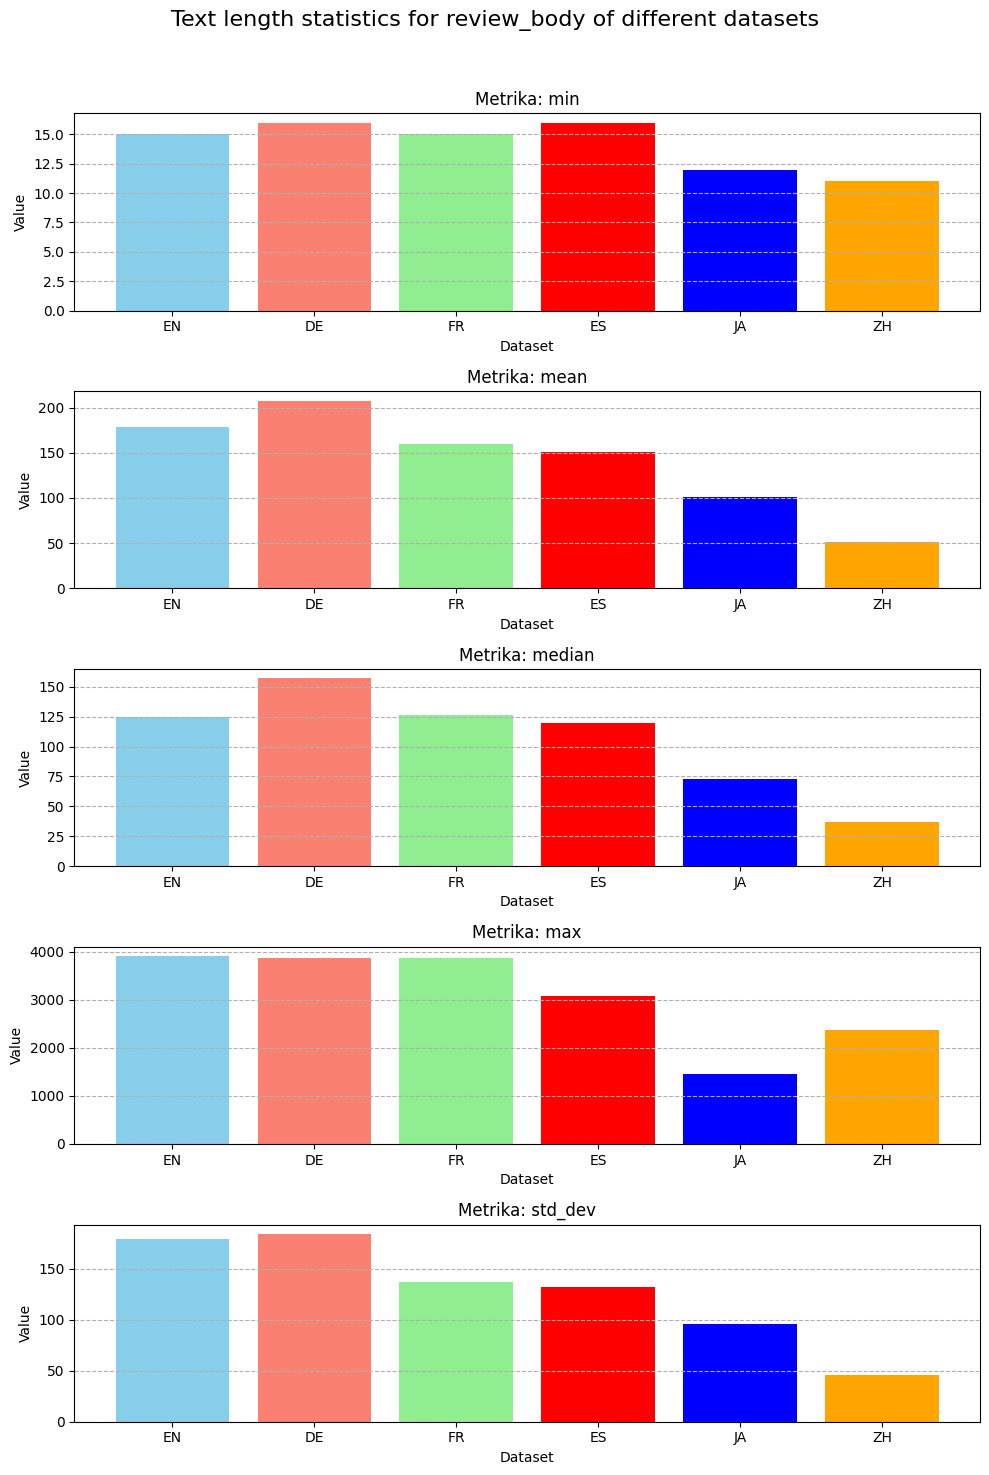

In [82]:
metrics = ["min", "mean", "median", "max", "std_dev"]
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 15))
fig.suptitle("Text length statistics for review_body of different datasets", fontsize=16)

for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_data = pandas_df[pandas_df["metric"] == metric]
    
    # Using Matplotlib for bar chart
    ax.bar(metric_data["dataset"], metric_data["value"], color=['skyblue', 'salmon', 'lightgreen', 'red', 'blue', 'orange'])
    ax.set_title(f"Metrika: {metric}")
    ax.set_ylabel("Value")
    ax.set_xlabel("Dataset")
    ax.grid(axis='y', linestyle='--')
    
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjusts the layout so that the title does not overlap
plt.show()

### ***review_title***

In [83]:
stats_list_two = [
    get_stats(en_pl_dataframe_finish, "EN", "lenght_review_title"),
    get_stats(de_pl_dataframe_finish, "DE", "lenght_review_title"),
    get_stats(fr_pl_dataframe_finish, "FR", "lenght_review_title"),
    get_stats(es_pl_dataframe_finish, "ES", "lenght_review_title"),
    get_stats(ja_pl_dataframe_finish, "JA", "lenght_review_title"),
    get_stats(zh_pl_dataframe_finish, "ZH", "lenght_review_title")
]

In [84]:
all_stats_two = pl.concat(stats_list_two)

In [85]:
stats_long_two = all_stats_two.unpivot(index=["dataset"], variable_name="metric", value_name="value")
pandas_df_two = stats_long_two.to_pandas()

#### ***Plotting graphs***

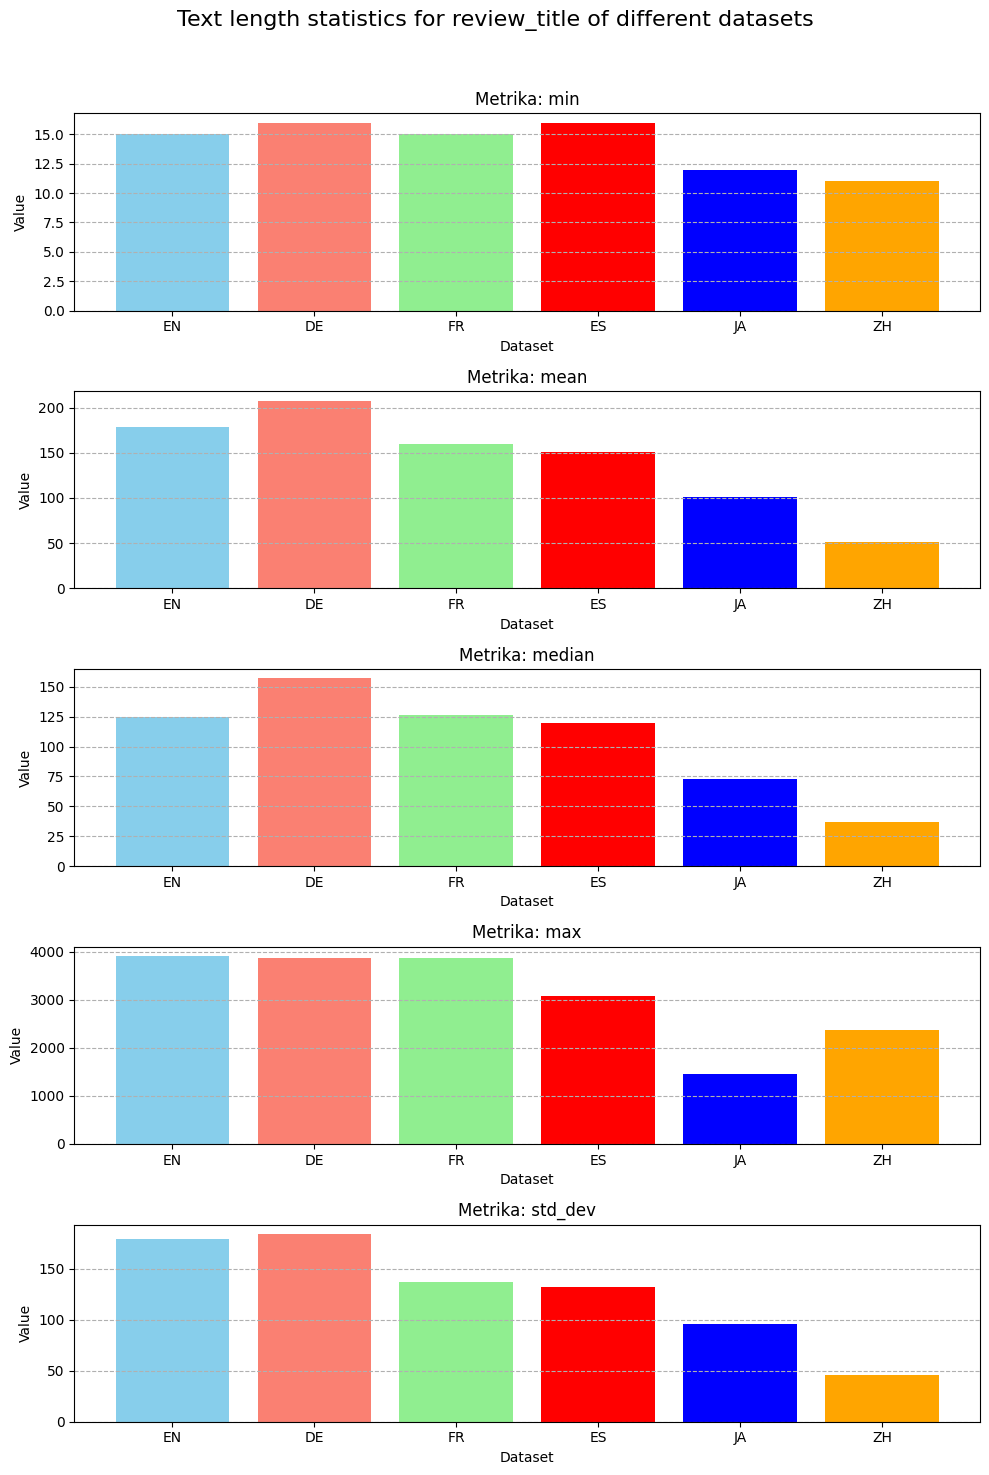

In [86]:
metrics = ["min", "mean", "median", "max", "std_dev"]
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 15))
fig.suptitle("Text length statistics for review_title of different datasets", fontsize=16)

for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_data = pandas_df[pandas_df["metric"] == metric]
    
    # Using Matplotlib for bar chart
    ax.bar(metric_data["dataset"], metric_data["value"], color=['skyblue', 'salmon', 'lightgreen', 'red', 'blue', 'orange'])
    ax.set_title(f"Metrika: {metric}")
    ax.set_ylabel("Value")
    ax.set_xlabel("Dataset")
    ax.grid(axis='y', linestyle='--')
    
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjusts the layout so that the title does not overlap
plt.show()

### ***product_category***

In [87]:
stats_list_three = [
    get_stats(en_pl_dataframe_finish, "EN", "lenght_product_category"),
    get_stats(de_pl_dataframe_finish, "DE", "lenght_product_category"),
    get_stats(fr_pl_dataframe_finish, "FR", "lenght_product_category"),
    get_stats(es_pl_dataframe_finish, "ES", "lenght_product_category"),
    get_stats(ja_pl_dataframe_finish, "JA", "lenght_product_category"),
    get_stats(zh_pl_dataframe_finish, "ZH", "lenght_product_category")
]

In [88]:
all_stats_three = pl.concat(stats_list_three)

In [89]:
stats_long_three = all_stats_three.unpivot(index=["dataset"], variable_name="metric", value_name="value")
pandas_df_three = stats_long_three.to_pandas()

#### ***Plotting graphs***

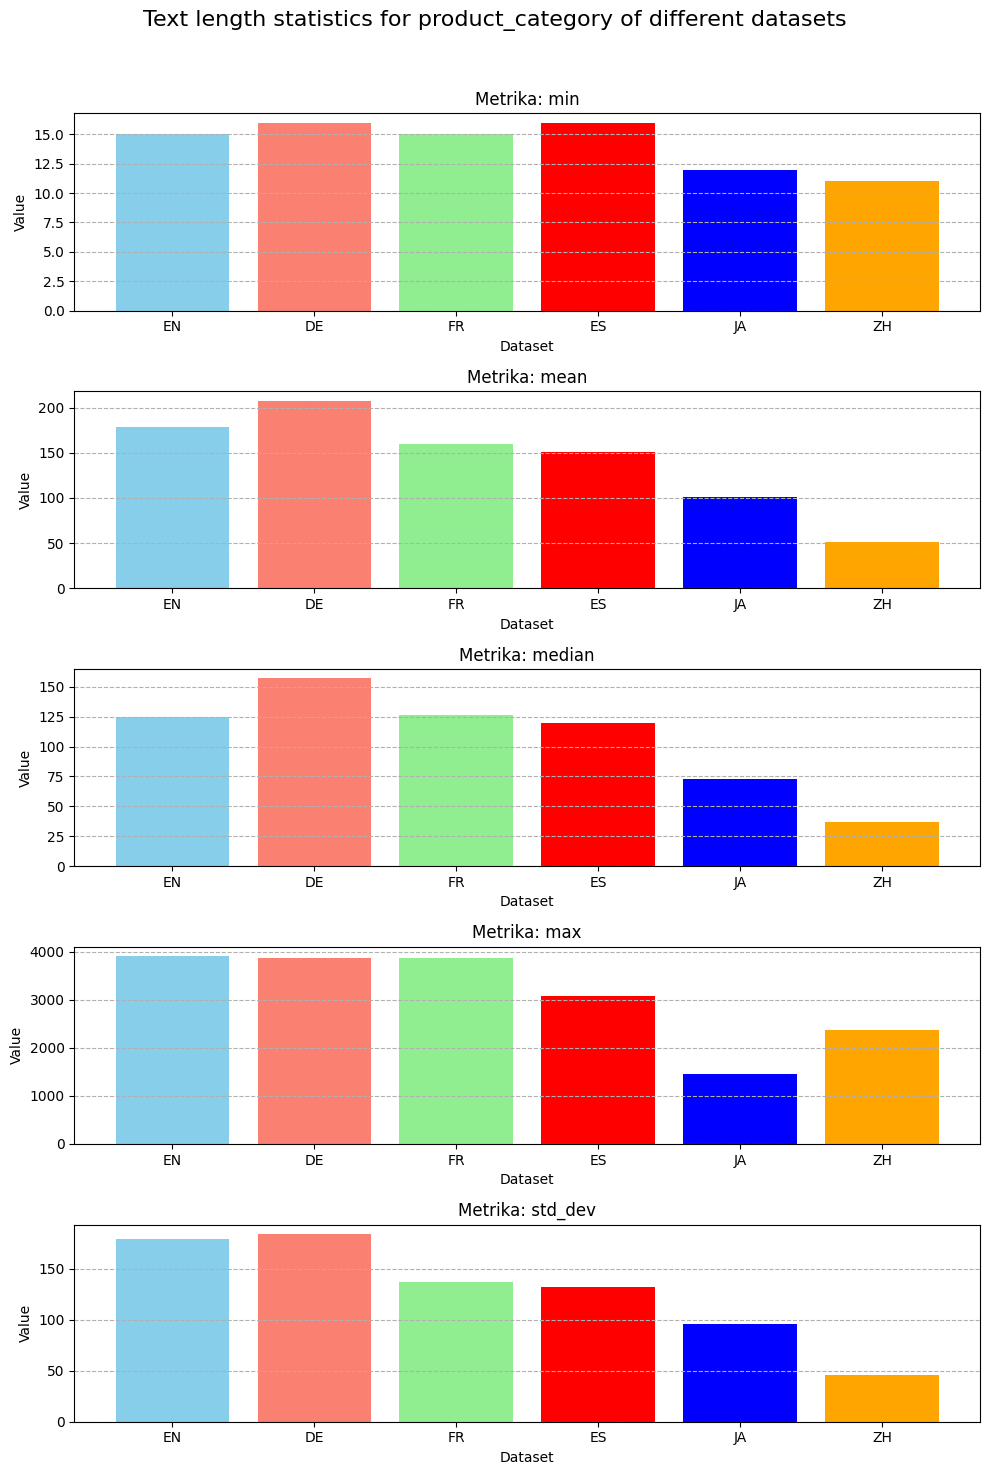

In [90]:
metrics = ["min", "mean", "median", "max", "std_dev"]
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 15))
fig.suptitle("Text length statistics for product_category of different datasets", fontsize=16)

for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_data = pandas_df[pandas_df["metric"] == metric]
    
    # Using Matplotlib for bar chart
    ax.bar(metric_data["dataset"], metric_data["value"], color=['skyblue', 'salmon', 'lightgreen', 'red', 'blue', 'orange'])
    ax.set_title(f"Metrika: {metric}")
    ax.set_ylabel("Value")
    ax.set_xlabel("Dataset")
    ax.grid(axis='y', linestyle='--')
    
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjusts the layout so that the title does not overlap
plt.show()

## **Splitting the dataset into train (95%), validation (2.5%) and test (2.5%)**

In [91]:
np.random.seed(42)

In [92]:
def datasets_dimension(datasets):
    total_rows = datasets.height
    train_size = int(0.95 * total_rows)
    
    remaining_size = total_rows - train_size
    val_size = int(0.50 * remaining_size)
    
    test_size = remaining_size - val_size
    
    return (test_size, train_size, val_size)

#### ***Values for distribution***

In [93]:
en_values = datasets_dimension(en_pl_dataframe_finish)
de_values = datasets_dimension(de_pl_dataframe_finish)
fr_values = datasets_dimension(fr_pl_dataframe_finish)
es_values = datasets_dimension(es_pl_dataframe_finish)
ja_values = datasets_dimension(ja_pl_dataframe_finish)
zh_values = datasets_dimension(zh_pl_dataframe_finish)

#### ***Split datasets***

In [94]:
def split_dataset(dataset, split_values):
    test_size = split_values[0]
    train_size = split_values[1]
    val_size = split_values[2]

    train_df = dataset.sample(n=train_size, shuffle=True)
    remaining_df = dataset.filter(~pl.col("id").is_in(train_df["id"]))
    val_df = remaining_df.sample(n=val_size, shuffle=True)
    test_df = remaining_df.filter(~pl.col("id").is_in(val_df["id"]))
    
    return (test_df, train_df, val_df)

In [95]:
en_df = split_dataset(en_pl_dataframe_finish, en_values)
de_df = split_dataset(de_pl_dataframe_finish, de_values)
fr_df = split_dataset(fr_pl_dataframe_finish, fr_values)
es_df = split_dataset(es_pl_dataframe_finish, es_values)
ja_df = split_dataset(ja_pl_dataframe_finish, ja_values)
zh_df = split_dataset(zh_pl_dataframe_finish, zh_values)

## **Overview of data set distribution**

### **English**

In [96]:
en_df_test = en_df[0]
print(en_df_test.shape)
en_df_test.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
8,4,"""Nice product used to a do it y…","""Only one I could find without …","""en""","""beauty""",167,37,6


In [97]:
en_df_train = en_df[1]
print(en_df_train.shape)
en_df_train.head(1)

(199500, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
21949,1,"""Spilled everywhere and all ove…","""One bubble will not cut it for…","""en""","""automotive""",58,40,10


In [98]:
en_df_valid = en_df[2]
print(en_df_valid.shape)
en_df_valid.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
185589,2,"""I love having my phone mounted…","""Magnet falls off.""","""en""","""wireless""",160,17,8


### **German**

In [99]:
de_df_test = de_df[0]
print(de_df_test.shape)
de_df_test.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
60,1,"""Versand dauerte länger Auf Stu…","""Unzufrieden...""","""de""","""personal_care_appliances""",305,14,24


In [100]:
de_df_train = de_df[1]
print(de_df_train.shape)
de_df_train.head(1)

(199500, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
29813,2,"""Der Wecker hat ein schönes Des…","""Schönes Design aber billig ver…","""de""","""home""",500,38,4


In [101]:
de_df_valid = de_df[2]
print(de_df_valid.shape)
de_df_valid.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
176136,1,"""Das mainboard ist bei mir kapu…","""Defekt angekommen""","""de""","""pc""",164,17,2


### **French**

In [102]:
fr_df_test = fr_df[0]
print(fr_df_test.shape)
fr_df_test.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
15,3,"""Tout est ok sauf le chargeur a…","""Dommage""","""fr""","""wireless""",233,7,8


In [103]:
fr_df_train = fr_df[1]
print(fr_df_train.shape)
fr_df_train.head(1)

(199500, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
40557,2,"""Petit, mais joli, très très fr…","""Très fragile.""","""fr""","""home_improvement""",145,13,16


In [104]:
fr_df_valid = fr_df[2]
print(fr_df_valid.shape)
fr_df_valid.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
171710,1,"""Je n’ai pas reçu le produit""","""Livraison non reçue""","""fr""","""drugstore""",27,19,9


### **Spanish**

In [105]:
es_df_test = es_df[0]
print(es_df_test.shape)
es_df_test.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
10,3,"""NO FUNCIONA DEMASIADO BIEN, FA…","""USB""","""es""","""home""",57,3,4


In [106]:
es_df_train = es_df[1]
print(es_df_train.shape)
es_df_train.head(1)

(199500, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
111516,1,"""No llegaron las hélices""","""Mal servicio""","""es""","""electronics""",23,12,11


In [107]:
es_df_valid = es_df[2]
print(es_df_valid.shape)
es_df_valid.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
33648,5,"""La mejor perfecta. Comodos, ta…","""Buena compra""","""es""","""shoes""",154,12,5


### **Japanese**

In [108]:
ja_df_test = ja_df[0]
print(ja_df_test.shape)
ja_df_test.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
12,4,"""屋外ＢＢＱでステーキや焼きに使用しました。 その後のメンテナ…","""IH 対応で便利""","""ja""","""home""",124,8,4


In [109]:
ja_df_train = ja_df[1]
print(ja_df_train.shape)
ja_df_train.head(1)

(199500, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
176059,1,"""倒れちゃうし、治らないし微妙だった。デザインはいいですが。。""","""んー""","""ja""","""home""",30,2,4


In [110]:
ja_df_valid = ja_df[2]
print(ja_df_valid.shape)
ja_df_valid.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
51301,1,"""2017年11月…524円 2018年02月…901円 合わ…","""値上げがね…""","""ja""","""pet_products""",65,6,12


### **Chinese**

In [111]:
zh_df_test = zh_df[0]
print(zh_df_test.shape)
zh_df_test.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
14,2,"""贴在里面窗户开不了，贴外面又没法粘导致一直往下掉。""","""不好用""","""zh""","""home""",25,3,4


In [112]:
zh_df_train = zh_df[1]
print(zh_df_train.shape)
zh_df_train.head(1)

(199500, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
189512,5,"""应该是正版。纸张很好，图画清晰，色彩鲜艳。""","""应该是正版。纸张很好，图画清晰，色彩鲜艳。""","""zh""","""book""",21,21,4


In [113]:
zh_df_valid = zh_df[2]
print(zh_df_valid.shape)
zh_df_valid.head(1)

(5250, 9)


id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
u32,i64,str,str,str,str,u32,u32,u32
118058,2,"""不好用。遥控器本身也要震动，且震动声音巨大。而且不能实现对跳…","""不好用，遥控器震动声音巨大。""","""zh""","""drugstore""",49,14,9


## **Create Hugging Face dataset**

We will create a new empty dataset on Hugging Face.

### **Convert Polars DataFrames to Arrow tables**

#### ***English***

In [114]:
en_df_train_arrow = en_df_train.to_arrow()
en_df_valid_arrow = en_df_valid.to_arrow()
en_df_test_arrow = en_df_test.to_arrow()

#### ***German***

In [115]:
de_df_train_arrow = de_df_train.to_arrow()
de_df_valid_arrow = de_df_valid.to_arrow()
de_df_test_arrow = de_df_test.to_arrow()

#### ***French***

In [116]:
fr_df_train_arrow = fr_df_train.to_arrow()
fr_df_valid_arrow = fr_df_valid.to_arrow()
fr_df_test_arrow = fr_df_test.to_arrow()

#### **Spanish**

In [117]:
es_df_train_arrow = es_df_train.to_arrow()
es_df_valid_arrow = es_df_valid.to_arrow()
es_df_test_arrow = es_df_test.to_arrow()

#### ***Japanese***

In [118]:
ja_df_train_arrow = ja_df_train.to_arrow()
ja_df_valid_arrow = ja_df_valid.to_arrow()
ja_df_test_arrow = ja_df_test.to_arrow()

#### ***Chinese***

In [119]:
zh_df_train_arrow = zh_df_train.to_arrow()
zh_df_valid_arrow = zh_df_valid.to_arrow()
zh_df_test_arrow = zh_df_test.to_arrow()

### **Save Arrow tables to local files**

In [120]:
!mkdir /kaggle/working/en
!mkdir /kaggle/working/de
!mkdir /kaggle/working/fr
!mkdir /kaggle/working/es
!mkdir /kaggle/working/ja
!mkdir /kaggle/working/zh

In [121]:
base_output_path = os.path.join("/kaggle","working")

output_path_en = os.path.join(base_output_path, "en")
output_path_de = os.path.join(base_output_path, "de")
output_path_fr = os.path.join(base_output_path, "fr")
output_path_es = os.path.join(base_output_path, "es")
output_path_ja = os.path.join(base_output_path, "ja")
output_path_zh = os.path.join(base_output_path, "zh")

In [122]:
# English
output_path_en_train = os.path.join(output_path_en, "train_en.parquet")
output_path_en_valid = os.path.join(output_path_en, "validation_en.parquet")
output_path_en_test = os.path.join(output_path_en, "test_en.parquet")

# German
output_path_de_train = os.path.join(output_path_de, "train.parquet")
output_path_de_valid = os.path.join(output_path_de, "validation.parquet")
output_path_de_test = os.path.join(output_path_de, "test.parquet")

# French
output_path_fr_train = os.path.join(output_path_fr, "train.parquet")
output_path_fr_valid = os.path.join(output_path_fr, "validation.parquet")
output_path_fr_test = os.path.join(output_path_fr, "test.parquet")

# Spanish
output_path_es_train = os.path.join(output_path_es, "train.parquet")
output_path_es_valid = os.path.join(output_path_es, "validation.parquet")
output_path_es_test = os.path.join(output_path_es, "test.parquet")

# Japanese
output_path_ja_train = os.path.join(output_path_ja, "train.parquet")
output_path_ja_valid = os.path.join(output_path_ja, "validation.parquet")
output_path_ja_test = os.path.join(output_path_ja, "test.parquet")

# Chinese
output_path_zh_train = os.path.join(output_path_zh, "train.parquet")
output_path_zh_valid = os.path.join(output_path_zh, "validation.parquet")
output_path_zh_test = os.path.join(output_path_zh, "test.parquet")

In [123]:
# English
pq.write_table(en_df_train_arrow, output_path_en_train)
pq.write_table(en_df_valid_arrow, output_path_en_valid)
pq.write_table(en_df_test_arrow, output_path_en_test)

print(f"Saved Arrow files: {output_path_en_train}, {output_path_en_valid}, {output_path_en_test}")

# German
pq.write_table(de_df_train_arrow, output_path_de_train)
pq.write_table(de_df_valid_arrow, output_path_de_valid)
pq.write_table(de_df_test_arrow, output_path_de_test)

print(f"Saved Arrow files: {output_path_de_train}, {output_path_de_valid}, {output_path_de_test}")

# French
pq.write_table(fr_df_train_arrow, output_path_fr_train)
pq.write_table(fr_df_valid_arrow, output_path_fr_valid)
pq.write_table(fr_df_test_arrow, output_path_fr_test)

print(f"Saved Arrow files: {output_path_fr_train}, {output_path_fr_valid}, {output_path_fr_test}")

# Spanish
pq.write_table(es_df_train_arrow, output_path_es_train)
pq.write_table(es_df_valid_arrow, output_path_es_valid)
pq.write_table(es_df_test_arrow, output_path_es_test)

print(f"Saved Arrow files: {output_path_es_train}, {output_path_es_valid}, {output_path_es_test}")

# Japanese
pq.write_table(ja_df_train_arrow, output_path_ja_train)
pq.write_table(ja_df_valid_arrow, output_path_ja_valid)
pq.write_table(ja_df_test_arrow, output_path_ja_test)

print(f"Saved Arrow files: {output_path_ja_train}, {output_path_ja_valid}, {output_path_ja_test}")

# Chinese
pq.write_table(zh_df_train_arrow, output_path_zh_train)
pq.write_table(zh_df_valid_arrow, output_path_zh_valid)
pq.write_table(zh_df_test_arrow, output_path_zh_test)

print(f"Saved Arrow files: {output_path_zh_train}, {output_path_zh_valid}, {output_path_zh_test}")


Saved Arrow files: /kaggle/working/en/train_en.parquet, /kaggle/working/en/validation_en.parquet, /kaggle/working/en/test_en.parquet
Saved Arrow files: /kaggle/working/de/train.parquet, /kaggle/working/de/validation.parquet, /kaggle/working/de/test.parquet
Saved Arrow files: /kaggle/working/fr/train.parquet, /kaggle/working/fr/validation.parquet, /kaggle/working/fr/test.parquet
Saved Arrow files: /kaggle/working/es/train.parquet, /kaggle/working/es/validation.parquet, /kaggle/working/es/test.parquet
Saved Arrow files: /kaggle/working/ja/train.parquet, /kaggle/working/ja/validation.parquet, /kaggle/working/ja/test.parquet
Saved Arrow files: /kaggle/working/zh/train.parquet, /kaggle/working/zh/validation.parquet, /kaggle/working/zh/test.parquet


### **Create a DatasetDict from Parquet files**

In [124]:
# English
dataset_dict_en = DatasetDict({
    "train": Dataset.from_parquet(output_path_en_train),
    "validation": Dataset.from_parquet(output_path_en_valid),
    "test": Dataset.from_parquet(output_path_en_test)
})

# German
dataset_dict_de = DatasetDict({
    "train": Dataset.from_parquet(output_path_de_train),
    "validation": Dataset.from_parquet(output_path_de_valid),
    "test": Dataset.from_parquet(output_path_de_test)
})

# French
dataset_dict_fr = DatasetDict({
    "train": Dataset.from_parquet(output_path_fr_train),
    "validation": Dataset.from_parquet(output_path_fr_valid),
    "test": Dataset.from_parquet(output_path_fr_test)
})

# Spanish
dataset_dict_es = DatasetDict({
    "train": Dataset.from_parquet(output_path_es_train),
    "validation": Dataset.from_parquet(output_path_es_valid),
    "test": Dataset.from_parquet(output_path_es_test)
})

# Japanese
dataset_dict_ja = DatasetDict({
    "train": Dataset.from_parquet(output_path_ja_train),
    "validation": Dataset.from_parquet(output_path_ja_valid),
    "test": Dataset.from_parquet(output_path_ja_test)
})

# Chinese
dataset_dict_zh = DatasetDict({
    "train": Dataset.from_parquet(output_path_zh_train),
    "validation": Dataset.from_parquet(output_path_zh_valid),
    "test": Dataset.from_parquet(output_path_zh_test)
})

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]


### **Define the repository name on Hugging Face**

In [125]:
repo_name_en = "KRadim/edit_amazon_reviews_multi_en"
#repo_name_de = ""
#repo_name_fr = ""
repo_name_es = "KRadim/edit_amazon_reviews_multi_es"
#repo_name_ja = ""
#repo_name_zh = ""

### **Upload the dataset to Hugging Face**

In [126]:
# English 
dataset_dict_en.push_to_hub(repo_name_en)
print(f"Dataset uploaded to Hugging Face at: https://huggingface.co/datasets/{repo_name_en}")

# German
#dataset_dict_de.push_to_hub(repo_name_de)
#print(f"Dataset uploaded to Hugging Face at: https://huggingface.co/datasets/{repo_name_de}")

# French
#dataset_dict_fr.push_to_hub(repo_name_fr)
#print(f"Dataset uploaded to Hugging Face at: https://huggingface.co/datasets/{repo_name_fr}")

# Spanish
dataset_dict_es.push_to_hub(repo_name_es)
print(f"Dataset uploaded to Hugging Face at: https://huggingface.co/datasets/{repo_name_es}")

# Japanese
#dataset_dict_ja.push_to_hub(repo_name_ja)
#print(f"Dataset uploaded to Hugging Face at: https://huggingface.co/datasets/{repo_name_ja}")

# Chinese
#dataset_dict_zh.push_to_hub(repo_name_zh)
#print(f"Dataset uploaded to Hugging Face at: https://huggingface.co/datasets/{repo_name_zh}")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/200 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|1         |  530kB / 30.3MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  67%|######7   |  535kB /  796kB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  66%|######6   |  528kB /  794kB            

README.md:   0%|          | 0.00/117 [00:00<?, ?B/s]

Dataset uploaded to Hugging Face at: https://huggingface.co/datasets/KRadim/edit_amazon_reviews_multi_en


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/200 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         |  530kB / 26.2MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  76%|#######5  |  530kB /  699kB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  76%|#######6  |  528kB /  691kB            

README.md:   0%|          | 0.00/118 [00:00<?, ?B/s]

Dataset uploaded to Hugging Face at: https://huggingface.co/datasets/KRadim/edit_amazon_reviews_multi_es
